<a href="https://colab.research.google.com/github/MahshidAlimi/ComputerVision/blob/master/Smile_Classification_using_Inception_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

I have both performed Portrait Segmentation and Smile classification on the CelebA dataset. Section A of the notebook is the transfer learning style portrait segmentation using the Mask RCNN model and utilising pre-trained COCO weights. On section B of the notebook, I used Inception V3 network for smile classification task. The training set was augmented before training, the validation set was used for hyperparameter tuning and the weights of the best model trained were saved. These weights were used during test time to predict smiling images on the corresponding test set. 

Portrait segmentation can be described as detection and segmentation of (often) the biggest object within an image. KNN matting, Bayesian matting and Closed-form matting models are few examples of pedestrian techniques that are often used and result into reasonable accuracies for the task at hand. There are two main drawbacks of models of this type for today's Machine Learning demands: Firstly, these models are not capable of detecting the label of the object in the image e.g. whether the image depicts a cat or a person. Secondly, these models require already created masks which act as ground truth that the model needs to predict. This requires defining which pixels belong to the background and which to the foreground. The CelebA dataset does not come with a set of pre-defined masks and hence going through the 220,599 images and creating the ground truth masks is not only labour intensive but also is computationally quite expensive which is beyond the scope of this project. Hence, I have chosen to use transfer learning from a pre-trained Mask RCNN model, which is considered to be the current state-of-the-art instance segmentation technique. It is not only capable of predicting the label of the object but also is capable of segmentation of the object without the need of labeling the pixels within an image. Mask RCNN is capable of detection of plethora of objects, however we only need to detect a person in the CelebA dataset hence the pre-trained COCO weights are used for this purpose. No model is trained from scratch for the portrait segmentation task but COCO weights are used to facilitate transfer learning.  


Smile classification on the other hand was computationally quite light as the CelebA dataset was already labelled. The motivation behind performing the smile classification task alongside portrait segmentation was to demonstrate my understanding of training and testing a model by removing the fully connected classifier of Inception V3 architecture and replacing it by a custom classification layer.


# Importing Libraries and Loading CelebA dataset

We will firstly start by importing the CelebA dataset from the Kaggle website. Cloning Mask RCNN model from github. Importing relevant libraries and setting global variables.  Please skip to the "Data Exploration" section.

In [0]:
import pandas as pd
from PIL import Image
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import copy

import os
import sys
from samples import coco
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn.model import log


from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD


from IPython.core.display import display, HTML
from io import BytesIO
import base64
from imutils import paths

Using TensorFlow backend.


In [0]:
# Importing the Celeba dataset from kaggle.
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.21G/1.21G [00:35<00:00, 35.2MB/s]
100% 1.21G/1.21G [00:35<00:00, 37.1MB/s]


In [0]:
# Unzipping files.
!unzip celeba-dataset.zip
!unzip img_align_celeba.zip

In [0]:
training_samples = 10000
validation_samples = 2000
test_samples = 2000
img_width = 178
img_height = 218
batch_size = 16
no_epochs = 20
no_samples = 100
images_folder='/content/img_align_celeba/'
example_im=images_folder + '009758.jpg'

# Data Exploration





The data exploration section will be applicable to both portrait segmentation and smile classification tasks.
By printing the length of the image folder, the number of images are within the dataset turns out to be 202,599 images.




In [0]:
# Loading the CelebA dataset.
imagePaths = sorted(list(paths.list_images('/content/img_align_celeba')))

f"There are {len(imagePaths)} images in the CelebA dataset."

'There are 202599 images in the CelebA dataset.'

The "list_attr_celeba.csv" contains all labels that are annotated for the dataset. The labels seem to be binary with label "1" indicating the presence of a certain attribute and label "-1" the lack of that attribute. For convenience, label "-1" is changed to 0. For example, when the male attribute has label "0", it means that the image is of a female. Furthermore, the shape of "df_attr" shows that there are 40 different labels for each image in the CelebA dataset.

In [0]:
# Reading the "list_attr_celeba" csv file.
df_attr = pd.read_csv('list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)

#The attributes are coded by 1 and -1. 
df_attr.replace(to_replace=-1, value=0, inplace=True) 

no_labels=(df_attr.shape)[1]
f"There are {no_labels} labels for each image."

'There are 40 labels for each image.'

Looping over the colomns to exctract the names of these fourty different labels.

In [0]:
print( 'List of available attributes are as follows:')
for j, i in enumerate(df_attr.columns):
    print(j , i)
   

List of available attributes are as follows:
0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


We tabulated these attributes for a subset of images showing their respective labels.




In [0]:
samples = df_attr.sample(frac=1, random_state=42).reset_index(drop=True)
samples.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,0,0,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,1,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0,1,1,1,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,1,...,0,1,1,0,1,0,0,0,0,0


We will draw a random image and look at a few of its labels. We can see that the person is smiling (label: 1), is a female (label :0), is young-ish (label: 1) and is wearing a pair of earrings (label: 1). The shape of each image is (218, 178, 3).


Smiling             1
Male                0
Young               1
Wearing_Earrings    1
Name: 009758.jpg, dtype: int64

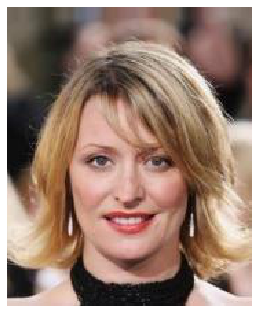

In [0]:
# Loading a pre-difined random image and plotting using the matplotlib Library.
random_image= load_img(example_im)
# Gets rid of the unwanted grid lines.
plt.grid(False)
# Gets rid of the unwanted y and x axes.
plt.xticks([]), plt.yticks([])
plt.imshow(random_image)
#some attributes
df_attr.loc[example_im.split('/')[-1]][['Smiling','Male','Young','Wearing_Earrings']] 
# 004387
# 009759

The recommended partitions by the CelebA dataset are displayed as follows:

*   Training set : 0
*   Validation set : 1
*    Test set : 2

The first five images seems to all belong to the training set.

In [0]:
df_partition = pd.read_csv('list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


The training set has 162,770 images, the validation set has 19,867 images and the test set contains 19,962 images within them.

In [0]:
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

The smiling attribute will be extracted for the smile classification task in section B of this notebook. We have joined the partitions with the smiling attribute for the first five images. 

In [0]:
# join the partition with the attributes
df_partition.set_index('image_id', inplace=True)

In [0]:
df_partition['partition'].value_counts().sort_index()
df_par_attr = df_partition.join(df_attr['Smiling'], how='inner')
df_par_attr.head()

,partition,Smiling
image_id,,
000001.jpg,0,1
000002.jpg,0,1
000003.jpg,0,0
000004.jpg,0,0
000005.jpg,0,0


It is vital to explore whether there exists an imbalance within the "smile" category. A significant class imbalance will perturb model towards the dominant class during training which increases the likelihood of inaccuracy in class prediction as the model tends to learn features that are more relevant to the dominant class. There are few possible strategies that can be used to combat dataset imbalance. One way is to shrink the dominant class by down sampling or otherwise to up-sample the smaller class by data augmentation to match up to the size of the more dominant class.  This notion only applies to the smile classification and not portrait segmentation task. The classification task can be performed for any of the forty attributes but here we have chosen the "smiling" category and as we can see there is not much imbalance within this attribute, thus neither of the mentioned techniques needs to be utilised.


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


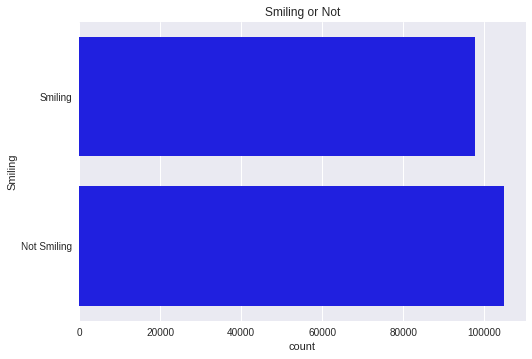

In [0]:
# Plotting the ratio between the Smiling and not similing attributes
# creating a deep copy of df_attr so that the 0 and 1 does not change in the main file.
df_copied_attr=copy.deepcopy(df_attr)
# replacing 1 and 0 with "Smiling" and "Not Smiling" respectively.
df_copied_attr.replace(to_replace=1 , value="Smiling", inplace=True)
df_copied_attr.replace(to_replace=0, value="Not Smiling", inplace=True)
# Plotting the histogram using Seaborn.
plt.title('Smiling or Not')
sns.countplot(y='Smiling', data=df_copied_attr, color="b")
plt.show()

The confusion matrix shows the relationship between attributions and their respective correlations. This may be important if we were using multiple number of the labels for a multi task learning model. However, as we are only using the "smile" class label, the information from the confusion matrix is not of much relevance. Nevertheless, it is quite important to study the relationships between the features of a dataset prior to applying any type of deep learning model.


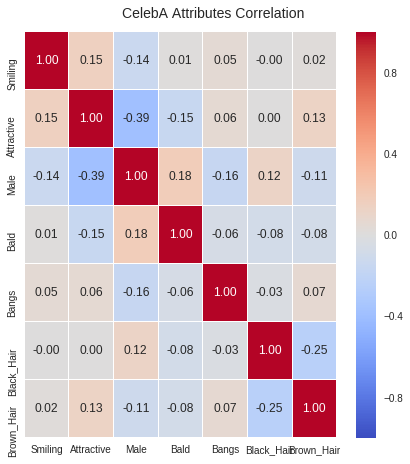

In [0]:
# set the size of the confusion matrix.
f, ax = plt.subplots(figsize=(7, 7))

# pick a sample of the attributes
subset_attr = ['Smiling', 'Attractive', 'Male', 'Bald', 'Bangs', 'Black_Hair', 'Brown_Hair']
corr = df_attr[subset_attr].corr()
# plot the matrix using seaborn
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('CelebA Attributes Correlation', fontsize=14)

#Transfer Learning

In context of the proposed challenges above, a common approach to a computer vision classification or segmentation task is to use a pre-existing model that has shown to result in reasonable accuracies. Thereby, the training set would be used for the model to learn underlying patterns and features from scratch. Tuning of the hyperparameters would be done on the validation set during the training session and finally the best saved weights would be used on the test set for the purposes of portrait segmentation or the prediction of the correct class label.  At first glance, this seems to be a logical approach to the task at hand however, this is computationally very expensive, will take a huge amount of time to train and will require a very large GPU. Hence, this approach is not the most optimal and efficient way to utilise available resources on Google Colab.

A better technique is to use transfer learning which uses already learnt features on a similar but separate large-scale datasets such as ImageNet (i.e. COCO weights from Microsoft) that have demonstrated to be an excellent resource for the task of transfer learning. These networks learn a set of rich, discriminating features to recognize 1,000 separate object classes. It makes sense that these filters can be reused for classification tasks other than what the CNN was originally trained on. There are two types of transfer learning when applied to deep learning for computer vision:

1. Treating networks as arbitrary feature extractors, meaning having a pre-trained CNN as feature extractor. Using this feature extractor, dataset of images is forward propagated through the network, the activations are extracted at a given layer and the values are saved.
2. Removing the fully-connected layers of an existing network, placing new fully connected layer set on top of the CNN, and fine-tuning these weights (and optionally previous layers) to recognize
object classes. 

The first approach is used in part A for portrait segmentation task and the second approach is in part B used for the Smile classification task.


#B) Smile Classification

As mentioned before there is a second type of transfer learning, one that can actually outperform the feature extraction (previous) method. The smile classification task seems to be perfect for this type of transfer learning which is often called fine-tuning. Application of fine-tuning allows to apply
pre-trained networks to recognize classes that they were not originally trained on.
 It requires to take out the final set of fully-connected layers (may be referred to as the head of the network) from a pre-trained CNN, in this case Inception V3 network. We then replace the head with a new set of fully-connected layers that has weight initialisation that have not been pre-trained specifically for the smile classification task (contrary to the COCO weights approach in the portrait segmentation task). From there all layers below the head are frozen so their weights cannot be updated and are kept the same. This means that the backward pass in back propagation does not reach them. The network also needs to be trained using very small learning rates (in our case 0.0001) to enable the new custom fully connected classifier to learn underlying patterns from the convolutional layers in the main body of the frozen network. 
We will carry on by implementing the smile classification task.




## 1B) Image Pre-processing

The portrait segmentation task is started after getting a good understanding of the CelebA dataset. We first begin by creating two function "load_img" and "generate_dataset" that help us load and pre-process the data.

It is good to note that the image processing libraries such as OpenCV and Scikit-image represent RGB (Red-Green-Blue) images as multidimensional Numpy arrays with shape (height, width, depth) instead of (width, height, depth) due to their inherited matrix notation. This is a *common catch* to be aware of. 

The Keras library provides the "img_to_array" function that accepts an input image and properly orders the channels. It efficiently prepares the images for training, validation and testing. Hence "load_reshape_img" function returns a new Numpy array with the channels properly ordered. The benefit of defining a function to handle this type of image pre-processing rather than simply calling img_to_array on every single image is that we can now chain pre-processors together as we load datasets from Kaggle.


Moreover, the raw pixel intensities are scaled since RGB coloured channels' intensity ranges from 0 to 255. The division by 255 handles normalizing raw pixel intensity values to the range 0 to 1. The motivation behind scaling the pixel intensities is to achieve consistencies for all the images in the dataset.





In [0]:
def load_img(fname):
#   Load the images
    img = load_img(fname)
#   Normalise pixel intensity 
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)
    return x

Here we will use the recommended partitions of the CelebA dataset to separate out the training, validation and test sets. We first start by concatenating the training and validation sets together. This way we can access both at training time. The images are loaded and reshaped into the desired dimensions and merged with their respective labels. Similar operation is done for the test set. The images need to be passed in batches (16 images per batch in our case) to the model, hence an extra dimension needs to be added to the array via "np.expand_dims" function. After calling this function, the images will have the shape of (batch, 178, 218, 3), where the first dimension belongs to the batch number.  Forgetting to add this extra dimension will result in an error when you call the ".predict" method of the model.



In [0]:
def generate_dataset(partition, attr, num_samples):
 
    # concat val and tarining sets with their labels and partitions    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_im = np.array([load_img(images_folder + fname) for fname in df_.index])
        x_im = x_im.reshape(x_.shape[0], 218, 178, 3)
        y_im = np_utils.to_categorical(df_[attr],2)
    # for Test
    else:
        x_im = []
        y_im = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), 
                            (img_width, img_height)).astype(np.float32) / 255.0
            # adding the batch dimension
            im = np.expand_dims(im, axis =0)
            x_im.append(im)
            y_im.append(target[attr])

    return x_im, y_im


According to Goodfellow et al., regularization is “any modification we make to a learning algorithm
that is intended to reduce its generalization error (test error), but not its training error”. In short,
regularization seeks to reduce our testing error perhaps at the expense of increasing training error
slightly. Regularisation techniques aim at the dynamics of bias-variance trade-off where they introduce bias to the training process in order to reduce variance when testing. Regularisation in deep learning is mostly reliant upon regularising the estimators in an effort to increase the bias for a reduction in model’s variance. Better regularisation methods manage to decrease the variance extensively for an insignificant increase in the bias term. Most deep learning models are prone to overfitting whereby true data-generating processes is taken into account alongside other data-generating processes that do not contribute to the model. Overfitting is thus the result of domination of variance rather than bias within the estimation error. The aim is to rid of irrelevant data-generating processes and match the model family being trained closer to the true data-generating process. 

Within Inception model's architecture there already exists *parameterized* forms of regularisation techniques which requiring us to update our loss/update
function. Regularisation can also be applied by changing the architecture of the network e.g. dropout and connection skipping regularisation. We will explain them in more depth when describing the architecture of the Inception model in section 2B. A fundamental regularisation technique is to gather more data which can be done by augmenting the data passed into the network for training. This method purposely perturbs training examples, changing their appearance slightly, before passing them into the network for training. The end result is that a network consistently sees “new” training data points generated from the original training data, partially alleviating the need for us to gather more training data. Our goal when applying data augmentation is to increase the generalizability of the model. Given that our network is constantly seeing new, slightly modified versions of the input data
points, it’s able to learn more robust features. At testing and validation time, we do not apply data augmentation. In most cases, there is an increase in testing accuracy, perhaps
at the expense at a slight dip in training accuracy which as stated earlier, is a typical characteristic of regularisation techniques.
In this case we can obtain additional training data from the original images by applying simple geometric transforms
such as random:
1. Translations
2. Rotations
3. Changes in scale
4. Shearing
5. Horizontal (and in some cases, vertical) flips.

Applying a small amount of these transformations to an input image will change its appearance slightly, but it does not change the class label. There are more advanced augmentation techniques (http://pyimg.co/j8ad8) which we did not exploit here. The "ImageDataGenerator" class from Keras is used for data augmentation and includes all relevant methods to help transform the input image.


In [0]:
# data augmentation genarator
datagen =  ImageDataGenerator(
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)


The best way to understand data augmentation is to simply visualize a given input being augmented and distorted. We have visualised one sample image after going through the data augmentation process. The sample image is loaded in the same fashion as the "load_img" function that was explained in details in Section 1A.  In short, sample image is converted it to a Keras-compatible array, and add an extra dimension to the image. The subplot wrapper from Matplotlib is used to print the ten images side by side in two rows. We can see a montage
of data augmentation examples. Notice how each image has been randomly rotated, sheared, zoomed, and horizontally flipped.


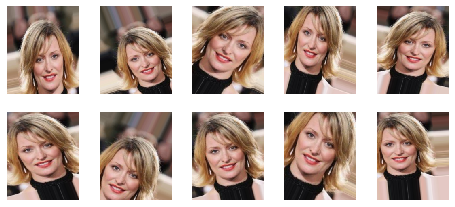

In [0]:
# load one image and reshape
img = load_img(example_im)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

aug = 0
for batch in datagen.flow(x, batch_size=1):
#   the subplot wrapper helps with printing the images side by side.
    plt.subplot(3, 5, aug+1)
    plt.grid(False)
    plt.xticks([]), plt.yticks([])
    plt.imshow( batch.reshape(218, 178, 3))
    
    if aug == 9:
        break
    aug += 1
plt.show()

Here we used the "generate_dataset" function and the recommended partitions within the CelebA dataset to extract the x_train (images) and y_train (the binary label which indicated the person in the image is smiling or not which is indicated by 0 and 1). 

Hereafter, we apply data augmentation to all images within the training set as per demonstrated.  




In [0]:
# creating the training images and their respective smiling labels.
# training set's partition in CelebA dataset is 0. 
x_train, y_train = generate_dataset(0, 'Smiling', training_samples)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(x_train, y_train,batch_size=batch_size)

We create the validation set using the recommended partitions from the CelebA dataset. Using the "generate_dataset" function and assigning "1" that indicates the validation partition. The validation set will be used for hyperparameter tuning, these parameter include the learning rate, dropout rate and the momentum parameter. 





In [0]:
# creating the validation in the same fashion as the training set.
x_valid, y_valid = generate_dataset(1, 'Smiling', validation_samples)

## 2B) Core Model

Inception V3 network is the model of choice for transfer learning style of smile classification as it is prominent for its excellent performance on diverse deep learning tasks. The Inception family networks is developed by Szegedy et al. at Google. These networks are named after their heavy reliance on the Inception modules. The input passed to these modules is processed by several branches of convolutional layers that are designed parallel to each other. At the end, the outputs from these modules are concatenated into a single tensor. An example of the Inception V3 branch is a (1 x 1) convolution followed by a (3 x 3) convolution network and their resulting features are merged together at the end. Such architecture, helps the model to more efficiently learn the spatial features and the channel-wise features by separating them out. The Keras framework offers the full Inception V3 architecture as "keras.applications.inception_v3.InceptionV3" which includes the pre-trained weights on the ImageNet dataset. Note that these weights are also in the format of HDF5 that were introduced earlier in the portrait segmentation section. The fully connected layer that is responsible for classification in the Inception V3 architecture is taken off and the main body of the model is used for feature extraction. It is a common practice to use the output of the very last layer as the fully connected layers are too specialised for the task that the network was initially trained for. Thus, the features that were learnt by these layers will not be useful for smile classification task. The features that are extracted from the convolutional layers are more general comparatively. Notice that the "include_top" parameter is set to false. This means that the Inception V3 network is built without its final fully connected layers that are responsible for classification and instead we will design a custom fully connected layer. Features are extracted after the final POOL layer rather than the old Softmax classifier when forward propagating an image through the network. The main body of the Inception model will remain untouched with its weights frozen and the newly designed custom classifying layer will be trained with a very small learning rate in order to obtain and learn relevant lower and higher level features from the body of the Inception V3 model.





In [0]:
# Import InceptionV3 Model
# https://github.com/kohpangwei/influence-release
inc_model = InceptionV3(weights='/content/influence-release/inception/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(img_height, img_width, 3))

print("number of layers:", len(inc_model.layers))

number of layers: 311


Here we build the custom fully connected layer classifier in Keras frame work. An average pooling layer is created before adding a perceptron layer with 1024 hidden units that are fed into a Relu activation function. A dropout regulariser is used on top of this layer. Dropout aids with regularisation by muting a percentage (in this case 50%) of hidden units meaning that the number of active hidden units are halved. It stochastically sets half the activations within a layer to zero for each training sample during training and has been shown to deliver significant gains in performance in many deep learning models. We have applied dropout to a fully connected layer here but research shows that it seems not be be greatly beneficial when applied convolutional layers. The next layer also consists of perceptron hidden units but as the number of the hidden units are decreased to 512 which enables the hidden units from the previous layer to connect in a linear fashion. The output of this layer is also passed through a Relu activation function which is then inputted to the prediction layer which consists of two units. This is the binary classification output which displays the likelihood of an image to belong to either "Smiling" or "Not Smiling" sub-categories. The likelihood is displayed through a Softmax function which normalises the outputted values in the range of 0 to 1.


In [0]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

The custom classifier is fed into to the main model by feeding in the prediction argument. However, we are not ready to train the model as of yet. As explained before the weights of the main body needs to be frozen to prevent their update during back propagation period. Keras has the "layer.trainable"  function that needs to be set to false. By looping through the layer of the model and freezing the weights we can accomplish the update prevention before training the custom classifier.

Moreover, the optimiser of our choice is set to be the Stochastic Gradient Descent with a very small learning rate of 0.0001 to allow the newly designed custom classifier to learn higher and lower level features from the earlier frozen convolutional layers. The momentum parameter helps with the optimisation process. It does it by saving the slope of the previous steps that were taken by the SGD optimiser and adds it as a small factor to its current update. This helps the optimiser to remember if it is going continuously towards a local/global minima or whether it is jumping all over the surface of the loss function which has been set to categorical cross entropy. Accuracy is also set as a metric which is really is 1-loss value, nonetheless it is an important attribute to look at as it gives an intuitive understanding of the performance of the classifier head that was attached to Inception V3 model. The values of learning rate, drop out rate and momentum will be tuned during the hyperparameter tuning phase that commences during testing the model on the validation set.


In [0]:
# Custom layers are fed into the main model
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Stops the main frozen body of the architecture to be updated through backprop
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

Checkpoint merely saves the model from the trained model to the correct directory. These weights will be used in the test time.





In [0]:
#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.smiling.hdf5', 
                               verbose=1, save_best_only=True)

Instead of calling the ".fit" method of model, ".fit_generator" needs to be used. This function is specially used at the instances where augmentation has been performed on the dataset. Hence, The first parameter that is passed to ".fit_generator" is "train_datagen.flow"  which was used in the  data augmentation process used and it requires to input to it the training set and its corresponding labels. 
The second argument passed to the generator is the batch size to aid the construction of the appropriately portioned batches of images while the network starts training. The validation set is then passed as a 2-tuple i.e. (x_valid, y_valid) which is used for validation purposes, i.e. hyperparameter tuning and acting as a prerequisite to the test set, at the end of every epoch. The parameter "steps_per_epoch" is in control of the number of batches per epoch which is determined by the division of the total number of training samples and the batch size, casted to an integer. Lastly, “the epochs” is in charge of the total number of the epoch, in this case 20 epochs, that the network is going to be trained for.




In [0]:
hist = model_.fit_generator(train_generator
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= training_samples//batch_size
                      , epochs= no_epochs
                      , callbacks=[checkpointer]
                      , verbose=1)

Epoch 1/20
625/625 [==============================] - 192s 307ms/step - loss: 0.6711 - acc: 0.5839 - val_loss: 0.5702 - val_acc: 0.7045

Epoch 00001: val_loss improved from inf to 0.57022, saving model to weights.best.inc.smiling.hdf5
Epoch 2/20
625/625 [==============================] - 177s 283ms/step - loss: 0.5571 - acc: 0.7117 - val_loss: 0.4086 - val_acc: 0.8220

Epoch 00002: val_loss improved from 0.57022 to 0.40863, saving model to weights.best.inc.smiling.hdf5
Epoch 3/20
625/625 [==============================] - 177s 283ms/step - loss: 0.4439 - acc: 0.7909 - val_loss: 0.3237 - val_acc: 0.8620

Epoch 00003: val_loss improved from 0.40863 to 0.32373, saving model to weights.best.inc.smiling.hdf5
Epoch 4/20
625/625 [==============================] - 177s 283ms/step - loss: 0.3856 - acc: 0.8317 - val_loss: 0.2901 - val_acc: 0.8785

Epoch 00004: val_loss improved from 0.32373 to 0.29007, saving model to weights.best.inc.smiling.hdf5
Epoch 5/20
625/625 [============================

## 3B) Evaluation of Results

The following plots demonstrate the loss and accuracy of the Inception V3 model on the smile classification task. The following graphs are quintessential in our understanding of the basic performance of the designed custom head during transfer learning. As we know, while training, the model learns underlying relationships and features and applies them to the validation set. Therefore, we can think of the validation set as a pre-test set. If the model was to overfit, we should expect the value of the validation loss to go up as the training loss goes down. This is due to the model learning the underlying noise instead of general patterns. This means that the features that are learnt are too specific and local to the training set. These features do not characterise the distribution that the images are drawn from and would not respond well to unseen images from the validation set. Hence, the model would be unable to predict the correct class for the images and will therefore incur large loss values. This is despite the fact that the training features will fit the training dataset too well and the training loss will artificially appear to gradually decrease over the time. 

The graph below plots values of the loss function of both training and validation datasets over the epochs. As we can see, the validation loss smoothly mimics the gradual decrease of the training loss, showing no sign of overfitting. 



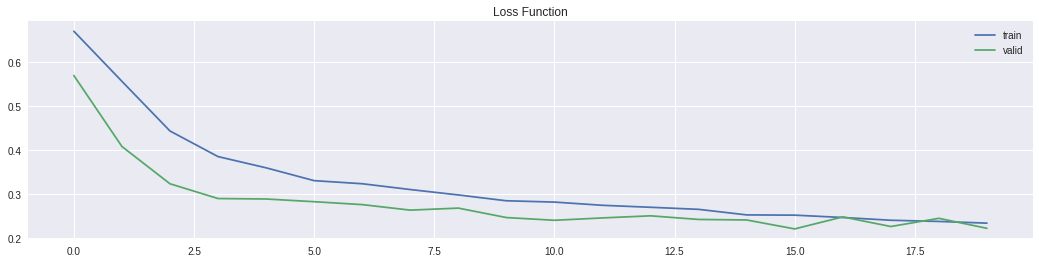

In [0]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

As mentioned before, the accuracy is calculated by deduction of the loss value from 1. It measures how successfully the model has been able to categorise each image to the correct class. By plotting accuracy against number of epochs, we observe that both training and validation sets achieve accuracies in low 90s, towards the end of the training session. The starting accuracy for the training set is 67.11% which is due to the fact that the fully connected layers are initialised by weights that do not exactly respond well to the task at hand but are not totally irrelevant either. If the weights were totally randomly initialised, we would expect the accuracy to be as low as 30%. At the start of the training session the custom head of the model starts to learn relevant features from the frozen body of the Inception model. Therefore, at the very beginning it is not able output very high accuracies. In a binary classification scenario, the rule of thumb is that an ensemble of weak learners should be able to output around 50% accuracy even if their choices are completely random with no established distinct input to label relationship. Therefore, our model is working better than random meaning that it is capable of utilising relevant features to categorise a sample image to a class label early on in the process.  At early stages, the network learns lower level features and as the training proceeds, the model will be able to learn more intricate higher level features from the frozen Inception network. This further advances capability of bucketing the images to their correct category. Hence, as mentioned before, the accuracy peaks rapidly after a few epochs.

Another interesting observation is that the validation set seems to be performing better throughout the epochs. This maybe due to two different factors. Firstly, the validation set uses the learnt features from the training set at the end of each epoch. Surprisingly, at the first epoch, the training accuracy is 67.11% while the validation accuracy is 70.45% which is a huge 3.34% difference, however this gap closes down as the epochs proceed. Thr monotonic increase in performance in both the training and validation sets is a clear indication of the absence of overfitting. A possible reason for the superior performance of the model on the validation set is that after every epoch, it tunes the hyperparameters of the model in order to better suit the hyperparameter's values to the objective loss function of the model and optimises the model's performance. These tunings are not applied to the training set at the very beginning and hence we see a performance gap between the training and validation accuracies. 


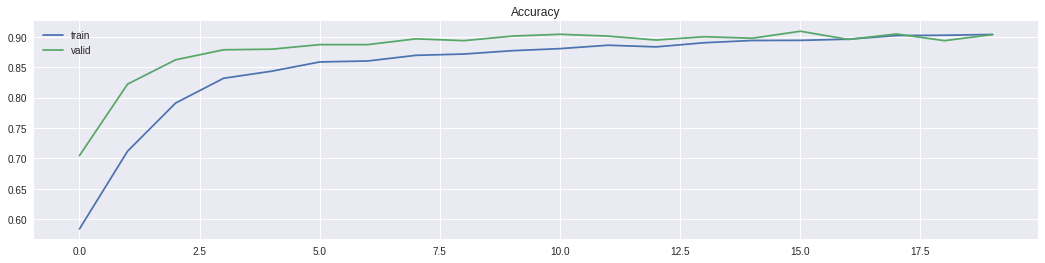

In [0]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['acc'], label = 'train')
plt.plot(hist.history['val_acc'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

Best weights that were obtained from extracting relevant features and optimised values of our hyperparameters are saved via checkpoint and are loaded here to be used on the unseen test set. Note that similar to the COCO weights that were used on the portrait segmentation task, the "weights.best.inc.smiling" is in the HDF5 format.


In [0]:
#load the best model
model_.load_weights('weights.best.inc.smiling.hdf5')

We extract the test images and labels using the "generate_dataset" function by using the "2" partition which indicates the test set in the CelebA dataset. We can now evaluate the fine-tuned network as well as serialize the weights. The "models_predictions" returns the index of the label with the highest predicted probability using "np.argmax" as it loops through all the images in the "x_test" container.  Here the accuracy is taken by summing up the number of labels that agree with the test label and dividing it by the number of samples in the test set. 

In binary classification, the preferred metric is the F1 score which uses the precision and the recall of the test set to compute the score. Precision is the number of correct positive results divided by the number of all positive results, and Recall is the number of correct positive results divided by the number of positive results that should have been returned. The F1 score can be interpreted as a weighted average of the precision and recall. The printed F1 score is the average of F1 scores for the "smiling" and "not smiling" labels and yields 0.89 which is very satisfactory given that we ran the model for only 20 epochs, which in the deep learning world is quite small.


Moreover, to raise the accuracy of the test set, we can consider a few tactics:

*   Leave the training session on for longer (since we did not detect evidence of overfitting).
*   Use all the images within the training set (i.e. use a larger training set).
*   Use more advanced data augmentation techniques on training set in order to create more data.
*   Unfreeze some earlier and later layers of the Inception V3 model. This will enable their weights to be updated and lower and higher level features to be adapted with respect to the task at hand.
*  Change the Inception V3 model to Xception which uses the skip connection method as well as the inception modules. 

Overall, the Inception V3 model has performed very satisfactory, if one takes into account the limited computanional resources that we had at our disposal.








In [0]:
# Test Data
xtest, ytest = generate_dataset(2, 'Smiling', test_samples)

# generate prediction
model_predictions = [np.argmax(model_.predict(test_images)) for test_images in xtest ]
# # meu.display_classification_report(true_labels=test_labels, 
#                                   predicted_labels=predictions, 
#                                   classes=list(labels_ohe_names.columns))

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==ytest) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(ytest, model_predictions))

Model Evaluation
Test accuracy: 88.5500%
f1_score: 0.8879099363680862
